In [1]:
L = 6;

In [2]:
using Random
using LinearAlgebra
using SparseArrays
using DelimitedFiles
file = raw"6_Grover_gates_data.txt" # Change for every L.
M = readdlm(file)
Gates_data_1 = M[:,1];
Gates_data_2 = M[:,2];
Gates_data_3 = M[:,3];

In [3]:
#DELTA = 0.01

In [4]:
#using DelimitedFiles
#file = raw"Noise_data.txt"
#M = readdlm(file)

In [5]:
Number_of_Gates = 2*(2*L^2-6*L+5)+2*L+4*L-4;
SEED = 20000#parse(Int64,ARGS[1]);
Random.seed!(SEED)
NOISE = 2*rand(Float64,Number_of_Gates).-1;

In [6]:
#length(NOISE)

In [7]:
I2 = [1 0; 0 1];
Z = [1 0;0 -1];
H = (1/sqrt(2))*[1 1;1 -1]
Rx(theta)=exp(-1im*(theta/2)*[1 1;1 1]);
Hadamard(noise) = exp(-1im*(pi/2+noise)*(I2-H)) #Ry(pi/2+noise)*Pauli_Z;
CX(noise) = exp(-1im*((pi/2+noise))*[1 1;1 1]);
Identity(dimension) = 1* Matrix(I, dimension, dimension);
int(x) = floor(Int,x);

In [8]:
#Hadamard(0.01)

In [9]:
function Matrix_Gate(Gate, Qubit) # Previously known as multi qubit gate.
    
    ## The case Qubit=1 is treated differently because we need to
    # initialize the matrix as U before starting the kronecker product.
    
    if Qubit == 1
        
        M = sparse(Gate)
        for i=2:L
            M = kron(M, sparse([1 0;0 1]))
        end
        
    else
        
        M = sparse([1 0;0 1])
        for i=2:L
            if i == Qubit
                M = kron(M, Gate)
            else
                M = kron(M, sparse([1 0;0 1]))
            end
        end
    end
    
    return M
end;

In [10]:
function CU(U,c,t)
    
    I2 = sparse([1 0;0 1])
    Z = sparse([1 0;0 -1])

    PI_0 = (I2+Z)/2
    PI_1 = (I2-Z)/2
     
    #function Rx(Noise)
        #A = cos((pi+Noise)/2)
        #B = -1im*sin((pi+Noise)/2)
        #return 1im*[A B;B A]
    #end
    
    Matrices = Dict("I" => I2,"PI_0" => PI_0,"U" => U, "PI_1" => PI_1)
    
    p0 = fill("I", L)
    p1 = fill("I", L)
    
    p0[c] = "PI_0"
    p1[c] = "PI_1"
    p1[t] = "U"

    
    PI_0_matrix = Matrices[p0[1]]
    for i = 2:L
        PI_0_matrix = kron(PI_0_matrix,Matrices[p0[i]])
    end        
        
    PI_1_matrix = Matrices[p1[1]]   
    for i = 2:L
        PI_1_matrix = kron(PI_1_matrix,Matrices[p1[i]])        
    end
           
    #return p0,p1
    return PI_0_matrix + PI_1_matrix     
end;

In [11]:
using PyCall
py"""
import numpy
import numpy.linalg
def adjoint(psi):
    return psi.conjugate().transpose()
def psi_to_rho(psi):
    return numpy.outer(psi,psi.conjugate())
def exp_val(psi, op):
    return numpy.real(numpy.dot(adjoint(psi),op.dot(psi)))
def norm_sq(psi):
    return numpy.real(numpy.dot(adjoint(psi),psi))
def normalize(psi,tol=1e-9):
    ns=norm_sq(psi)**0.5
    if ns < tol:
        raise ValueError
    return psi/ns
def is_herm(M,tol=1e-9):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M-adjoint(M)
    return max(numpy.abs(diff.flatten())) < tol
def is_unitary(M,tol=1e-9):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M.dot(adjoint(M))-numpy.identity((M.shape[0]))
    return max(numpy.abs(diff.flatten())) < tol
def eigu(U,tol=1e-9):
    (E_1,V_1)=numpy.linalg.eigh(U+adjoint(U))
    U_1=adjoint(V_1).dot(U).dot(V_1)
    H_1=adjoint(V_1).dot(U+adjoint(U)).dot(V_1)
    non_diag_lst=[]
    j=0
    while j < U_1.shape[0]:
        k=0
        while k < U_1.shape[0]:
            if j!=k and abs(U_1[j,k]) > tol:
                if j not in non_diag_lst:
                    non_diag_lst.append(j)
                if k not in non_diag_lst:
                    non_diag_lst.append(k)
            k+=1
        j+=1
    if len(non_diag_lst) > 0:
        non_diag_lst=numpy.sort(numpy.array(non_diag_lst))
        U_1_cut=U_1[non_diag_lst,:][:,non_diag_lst]
        (E_2_cut,V_2_cut)=numpy.linalg.eigh(1.j*(U_1_cut-adjoint(U_1_cut)))
        V_2=numpy.identity((U.shape[0]),dtype=V_2_cut.dtype)
        for j in range(len(non_diag_lst)):
            V_2[non_diag_lst[j],non_diag_lst]=V_2_cut[j,:]
        V_1=V_1.dot(V_2)
        U_1=adjoint(V_2).dot(U_1).dot(V_2)
    # Sort by phase
    U_1=numpy.diag(U_1)
    inds=numpy.argsort(numpy.imag(numpy.log(U_1)))
    return (U_1[inds],V_1[:,inds]) # = (U_d,V) s.t. U=V*U_d*V^\dagger
"""

In [12]:
U_0 = Identity(2^L)#[-1 0 0 0; 0 1 0 0; 0 0 1 0;0 0 0 1];
U_0[1,1] = -1
A = ones(2^L,2^L);
U_x = (2/2^L)*A-Identity(2^L); # 2\s><s|-I
G_exact = U_x*U_0
V = py"eigu"(G_exact)[2];

### Grover matrix constructed from data file

In [13]:
function x_bar(n)
    k_n = (2*pi*n)/(2^L-2)
    s = zeros(2^L-2,1)
    for j = 1:2^L-2
        sigma_z_basis = zeros(2^L-2,1);
        sigma_z_basis[j] = 1
        s += exp(1im*j*k_n) * sigma_z_basis
    end
    return s/sqrt(2^L-1)
end;
#= 
The following function returns the basis transformation matrix U such that
U\x_bar_k> = \k> for k = 1 2 ... 2^L-2. The two special states are neglected. 
=#
function Basis_Change_Matrix()
    local U = zeros((2^L)-2,(2^L)-2)
    for k = 1:2^L-2
        sigma_z_basis = zeros(2^L-2,1);
        sigma_z_basis[k] = 1
        U += sigma_z_basis * (x_bar(k))'
    end
    return U
end;

In [14]:
#DELTA = 0.01
function Eigenvalues(DELTA)
    
    U_list = [];
    U_noise_list = [];
    U_x_delta = sparse(Identity(2^L));
    #ux_list = []
    NOISE_list = []

    Gates_data_new_1 = []
    Gates_data_new_2 = []
    Gates_data_new_3 = []
    
    # U_x
    for i = (2*L^2-4*L+5)+1 : 2*(2*L^2-6*L+5)+2*L+4*L-4
        if Gates_data_1[i] == "H"
            
            
            epsilon = NOISE[i]
            push!(NOISE_list,epsilon)
            h_matrix = Matrix_Gate(Hadamard(DELTA*epsilon), Gates_data_3[i])
            U_x_delta *= h_matrix
        
            push!(Gates_data_new_1,"H")
            push!(Gates_data_new_2,0.0)
            push!(Gates_data_new_3,Gates_data_3[i])
        
            push!(U_noise_list,h_matrix) # Noise.
        
            push!(U_list,Matrix_Gate(Hadamard(0.0), Gates_data_3[i])) # Noiseless.
            
        elseif Gates_data_1[i] == "X"
        
            epsilon = NOISE[i]
            push!(NOISE_list,epsilon)        
            x_matrix = Matrix_Gate(CX(DELTA*epsilon),Gates_data_3[i])
            U_x_delta *= x_matrix
        
            push!(Gates_data_new_1,"X")
            push!(Gates_data_new_2,0.0)
            push!(Gates_data_new_3,Gates_data_3[i]) 
        
            push!(U_noise_list,x_matrix) # Noise.
        
            push!(U_list,Matrix_Gate(CX(0.0),Gates_data_3[i])) # Noiseless.
            
        else
            #push!(ux_list,"CRX")
        
            epsilon = NOISE[i]
            push!(NOISE_list,epsilon)        
            rx_matrix = CU(Rx(Gates_data_1[i]+DELTA*epsilon), Gates_data_2[i], Gates_data_3[i])
            U_x_delta *= rx_matrix
        
            push!(Gates_data_new_1,Gates_data_1[i])
            push!(Gates_data_new_2,Gates_data_2[i])
            push!(Gates_data_new_3,Gates_data_3[i])
        
            push!(U_noise_list,rx_matrix) # Noise.
        
            push!(U_list,CU(Rx(Gates_data_1[i]), Gates_data_2[i], Gates_data_3[i])) # Noiselss.
            
        end
    end
    
    U_0_delta = sparse(Identity(2^L));
    
    #u0_list = []
    # U_0
    for i = 1 : 2*L^2-4*L+5
        if Gates_data_1[i] == "H"
        
            epsilon = NOISE[i]
            push!(NOISE_list,epsilon)        
            h_matrix = Matrix_Gate(Hadamard(DELTA*epsilon), Gates_data_3[i])
            U_0_delta *= h_matrix
        
            push!(Gates_data_new_1,"H")
            push!(Gates_data_new_2,0.0)
            push!(Gates_data_new_3,Gates_data_3[i])
        
            push!(U_noise_list,h_matrix) # Noise.
        
            push!(U_list,Matrix_Gate(Hadamard(0.0), Gates_data_3[i])) # Noiseless.
            
        elseif Gates_data_1[i] == "X"

        
            epsilon = NOISE[i]
            push!(NOISE_list,epsilon)        
            x_matrix = Matrix_Gate(CX(DELTA*epsilon),Gates_data_3[i])
            U_0_delta *= x_matrix
        
            push!(Gates_data_new_1,"X")
            push!(Gates_data_new_2,0.0)
            push!(Gates_data_new_3,Gates_data_3[i]) 
        
            push!(U_noise_list,x_matrix) # Noise.
        
            push!(U_list,Matrix_Gate(CX(0.0),Gates_data_3[i])) # Noiseless.
            
        else
            #push!(u0_list,"CRX")
        
            epsilon = NOISE[i]
            push!(NOISE_list,epsilon)        
            rx_matrix = CU(Rx(Gates_data_1[i]+DELTA*epsilon), Gates_data_2[i], Gates_data_3[i])
            U_0_delta *= rx_matrix
        
            push!(Gates_data_new_1,Gates_data_1[i])
            push!(Gates_data_new_2,Gates_data_2[i])
            push!(Gates_data_new_3,Gates_data_3[i])
        
            push!(U_noise_list,rx_matrix) # Noise.
        
            push!(U_list,CU(Rx(Gates_data_1[i]), Gates_data_2[i], Gates_data_3[i])) # Noiseless.
            
        end
    end
        
    GROVER_DELTA = U_x_delta*U_0_delta
    
    function kth_term(k)

            f_k = Identity(2^L);
    
            for i = k:length(U_list)-1
                f_k = f_k*collect(U_list[length(U_list)-i+k])
            end     
            #= Corresponding H for the kth term. =#
            if Gates_data_new_1[k] == "H"

                Qubit = Gates_data_new_3[k] # qubit.
                H_k = Matrix_Gate(I2-H,Qubit) #= H_had = I2-Had. =#

            elseif Gates_data_new_1[k] == "X"

                Qubit = Gates_data_new_3[k] # qubit.
                H_k = Matrix_Gate([1 1;1 1],Qubit) #= H_X = X+I2. =#

            else
        
                Angle = Gates_data_new_1[k]
                Control_Qubit = int(Gates_data_new_2[k])
                Target_Qubit = int(Gates_data_new_3[k])
                #= H = ((I-Z)/2)_c \otimes ((I+X)/2)_t.=#
                Matrices = Dict("I" => [1 0;0 1],"U" => [1 1;1 1]/2, "PI_1" => (I2-Z)/2)
                p1 = fill("I", L)
                p1[Control_Qubit] = "PI_1"
                p1[Target_Qubit] = "U"
                H_k = Matrices[p1[1]]
                for i = 2:L
                    H_k = kron(H_k,Matrices[p1[i]])
                end                                 
            end
    
    
        return f_k*H_k*(f_k')
    end;        
    
    EIGU = py"eigu"(collect(GROVER_DELTA))
    E_exact = real(1im*log.(EIGU[1])); # Eigenvalue.
    E_exact = E_exact[2:2^L-1]; #= Neglecting the two special states at 1 and 2^L. =#
    
    #= The following loop sums over all epsilon to get H_eff. =#
    h_eff = zeros(2^L,2^L);
    for i = 1:length(U_list)
        h_eff += NOISE_list[i]*kth_term(i)
    end        

    # Converting matrix in Z basis to matrix in |0> and |xbar> basis.
    h_eff_D = (V')*h_eff*(V)
    # |0> and |xbar> basis states are deleted.
    h_eff_D = h_eff_D[3:2^L,3:2^L]
    
    #= To calculate KL divergence we need eigenvectors in \sigma_{Z} basis
     aka computational basis. Therefore h_eff_D need to be converted to \sigma_{Z} basis again.=#
    # Converting to Sigma_z basis.
    h_eff_z = Basis_Change_Matrix()' * h_eff_D * Basis_Change_Matrix() 
    
    #=
    # |0> and |xbar> basis states are deleted.
    h_eff_D = exp(-1im*h_eff_D[3:2^L,3:2^L])
    E_eff_D = py"eigu"(h_eff_D)[1] # Matrix is diagonalized.
    E_eff_D = real(1im*log.(E_eff_D)) # Extracing phi_f from exp(-i*phi_F).
    E_eff_D_sorted = sort(real(E_eff_D),rev = true); # Soring the eigenvalues in descending order.

    
    return E_exact, E_eff_D_sorted
    =#
    
    
    return eigvecs(h_eff_z)
end;

### Comparing exact and effective energies

In [15]:
#delta = 0.1
Eff = Eigenvalues(delta)[2];

LoadError: UndefVarError: delta not defined

In [16]:
for i = 2:2^L-3
    #push!(E_number,i)
    #push!(r_n,Level_Statistics(i,Eff_asc))
    py"Write_file"(i,Level_Statistics(i,Eff))
end

LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/sasankadowarah/.julia/packages/PyCall/ygXW2/src/pyeval.jl:38 =# @pysym(:PyEval_EvalCode), PyPtr, (PyPtr, PyPtr, PyPtr), o, globals, locals))))) <class 'NameError'>
NameError("name 'Write_file' is not defined")
  File "/Users/sasankadowarah/.julia/packages/PyCall/ygXW2/src/pyeval.jl", line 1, in <module>
    const Py_single_input = 256  # from Python.h


### KL divergence

In [17]:
V = Eigenvalues(0.0);

In [18]:
function KLd(n,Eigenvectors_Matrix)
    
    pf(i) = abs((Eigenvectors_Matrix[1:2^L-2,n:n])[i])^2
    
    KLd_sum = 0.0
    for i = 1:2^L-3
        p = pf(i)
        q = pf(i+1)
        KLd_sum += p*log(p/q)
    end
    
    return KLd_sum
end;

In [19]:
KL = []
for i = 1:2^L-2
    push!(KL,KLd(i,V))
end

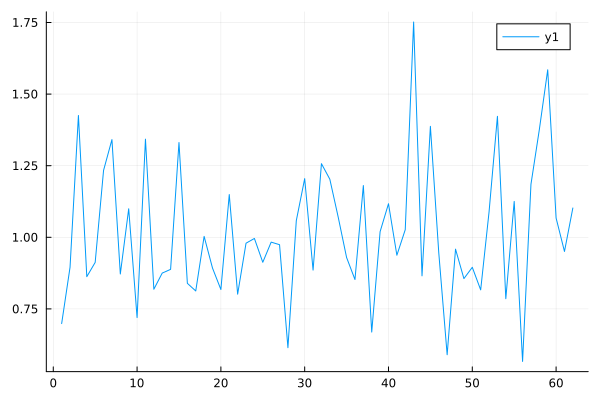

In [20]:
#using Plots
#plot(KL)